# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network mostly by yourself.

When you are finished with the assignment make sure you submit the following files:
1. this file (ML_DL_Assignment3.ipynb) compressed to zip.
2. the functions file (ML_DL_Functions3.py).
3. the model parameters for the first model from section 3.3 ('best_CNN_model.pk').
4. the model parameters for the second model from section 3.3 ('best_CNNChannel_model.pk').

## Grading Method
In this assignment you are given alot more freedom to implement your own models and training proccedures. Yet we still need an automatic method for testing your codes. This means that there are a few things which have to be done correctly in order for the testing to pass:
1. Your preprocessing has to be exactly the same as the preprocessing done on the test set. To ensure this happens you got a small sample of validation images to compare your preprocessing to the test.
2. your models have to be written in pytorch, they have to accept the correct input shape and output the correct shape and type.
3. your models will be instantiated on the testing server without any arguments so make sure to not include any in your models.
4. The values in the output of the model should have the correct meaning. For that reason you were given a prewritten get_accuracy function. make sure it works with your model without changing the function.

In [11]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import sys
from PIL import Image
import os


def reload_functions():
  if 'ML_DL_Functions3' in sys.modules:
    del sys.modules['ML_DL_Functions3']
  functions_path = drive_path.replace(" ","\ ") + 'ML_DL_Functions3.py'
  !cp $functions_path .

## 1. Data

Download the data from the course website. make sure you have both the template python functions file and the dataset data directory on the same directory in your google drive.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/Colab Notebooks/ML HW3/' # TODO - UPDATE ME WITH THE TRUE PATH!
reload_functions()
import ML_DL_Functions3


Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### 1.1 Loading and Preprocessing the data

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `Image.open`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
**The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1.** Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [13]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
train_path = drive_path + "data/train/*.jpg"
test_w_path = drive_path + "data/test_w/*.jpg"
test_m_path = drive_path + "data/test_m/*.jpg"

def reshape(data_array):
  # create a new array of the dimension we want
    tripels_array = int(len(data_array)/6)
    new_array = np.zeros((tripels_array, 3, 2,224,224,3))
    #triplets
    for i in range(tripels_array):
      #each triples
        for j in range(3):
          #each pair
            for k in range(2):
                new_array[i, j, k] = data_array[6*i+2*j+k]

    return new_array


#images = {}
train_images =[]
test_w_images =[]
test_m_images =[]

#maybe doing is sorted
# for train
for i , file in enumerate(sorted(glob.glob(train_path))):
  #  filename = file.split("/")[-1]            # get the name of the .jpg file
    img_train = np.asarray(Image.open(file))        # read the image as a numpy array
    img_train = img_train[:, :, :3]          # remove the alpha channel
    img_train = (img_train/255.0) - 0.5
    train_images.append(img_train)
print(i)
#for the test_w
for j , file in enumerate(sorted(glob.glob(test_w_path))):
  #  filename = file.split("/")[-1]            # get the name of the .jpg file
    test_w = np.asarray(Image.open(file))        # read the image as a numpy array
    test_w = test_w[:, :, :3]          # remove the alpha channel
    test_w = (test_w/255.0) - 0.5
    test_w_images.append(test_w)

#for the test_m
for k , file in enumerate(sorted(glob.glob(test_m_path))):
  #  filename = file.split("/")[-1]            # get the name of the .jpg file
    test_m = np.asarray(Image.open(file))        # read the image as a numpy array
    test_m = test_m[:, :, :3]          # remove the alpha channel
    test_m = (test_m/255.0) - 0.5
    test_m_images.append(test_m)

train_data_array = np.array(train_images)

#to get 80% and also diveded by 6
slice_length_80_percent = int(len(train_data_array) * 0.8)
slice_length_80_percent -= slice_length_80_percent % 6


train_data =  train_data_array[:slice_length_80_percent]
train_data = reshape(train_data)
print(train_data.shape)
valid_data = train_data_array[slice_length_80_percent:]
valid_data = reshape(valid_data)
print(valid_data.shape)
#for the man shoes
test_m_data  = np.array(test_m_images)
test_m_data = reshape(test_m_data)
print(test_m_data.shape)
#for the women shoes

test_w_data  = np.array(test_w_images)
test_w_data = reshape(test_w_data)
print(test_w_data.shape)



671


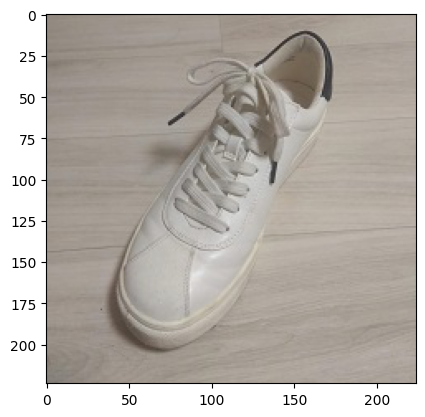

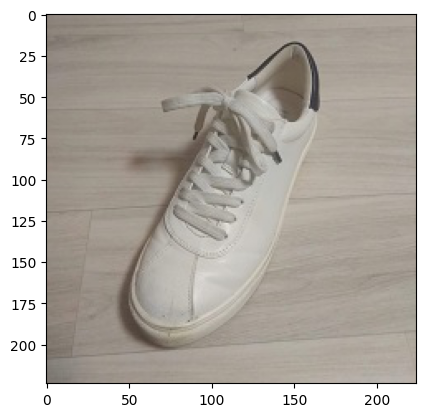

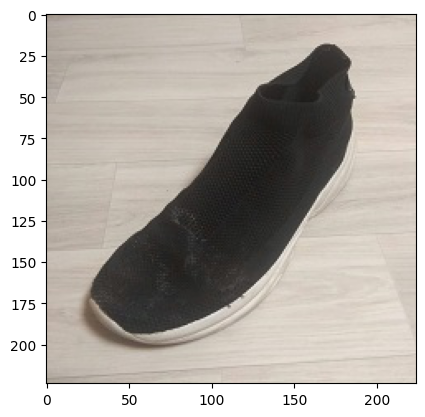

In [14]:
# Run this code
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### 1.2 Generating Same Pairs

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


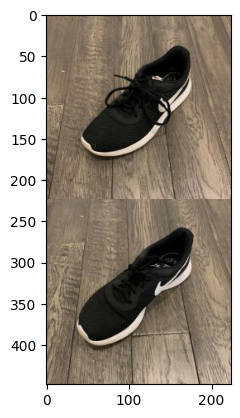

In [15]:
# Your code goes here

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]

def generate_same_pair(data_array):
    # Initialize an empty list to store concatenated pairs
    concatenated_pairs = []

    # Iterate over each triplet in the dataset
    for triplet in data_array:
        # Concatenate the images of left and right shoes along the height axis
        pair_concatenated = np.concatenate((triplet[:, 0], triplet[:, 1]), axis=1)
        # Append the concatenated pair to the list
        concatenated_pairs.append(pair_concatenated)
    # Stack the concatenated pairs together to form a single array
    concatenated_pairs_array = np.stack(concatenated_pairs, axis=0)
    concatenated_pairs_array = concatenated_pairs_array.reshape(-1, 448, 224, 3)
    return concatenated_pairs_array


print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### 1.3 Generate Different Pairs

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


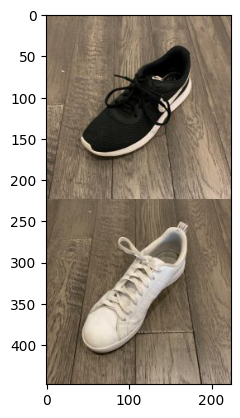

In [16]:
# Your code goes here
def generate_different_pair(data):
  num_triplets = len(data) #set the number of triplets
  different_pairs = np.zeros((num_triplets*3,448,224,3)) #make the output shape
  for triplet_number in range(num_triplets):
      for pair_number in range(3):
          left_shoe = data[triplet_number, pair_number, 0]
          right_shoe = data[triplet_number, (pair_number+1)%3, 1]
          different_pairs[triplet_number*3+pair_number] = np.concatenate((left_shoe, right_shoe), axis=0)
  return different_pairs

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

#### Food for thought

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.



### 2.1 Convolutional Model

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

make sure the CNN's constructor(__init__) function has no arguments. Instantiate the variable $n$ inside the constructor(__init__) of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.
make sure the output of the model has a shape of (N,2) where N is the batch_size.

### 2.2 Channeled Convolutional Neural Network

Open the functions file(ML_DL_Functions3.py) and Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

make sure the output of the model has a shape of (N,2) where N is the batch_size.

#### Food for thought

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. why would one of these models perform better?

### 2.3 Get Accuracy

The function `get_accuracy` is written for you.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.

In [18]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

#### Food for thought
why do we wish to track the false positives and false negatives separately?

## 3. Training

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target. We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### 3.1 train model

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch.

In [19]:
# you can change the signature and structure of this function as you please
# the code and comments below are only a suggestion to get you started
def train_model(model,train_data=train_data,test_m_data = test_m_data,test_w_data = test_w_data,validation_data=valid_data,batch_size= 32, learning_rate= 0.001,
                weight_decay= 1e-4, epochs= 30,  checkpoint_path="checkpoints/" , model_name = "", train = False , type=type):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # if model_name == 'CNNChannel':
    #   scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # else:
    if type == 1:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    elif type == 2:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.05)


    # creating the train and vali
    pos_paris_train = generate_same_pair(train_data)
    neg_paris_train = generate_different_pair(train_data)

    pos_paris_valid = generate_same_pair(validation_data)
    neg_paris_valid = generate_different_pair(validation_data)

    # creation of labels with np.one and np.zeros as demands and put them in the same line [1,1,1,0,0,0]
    train_labels = np.concatenate([np.ones(batch_size // 2), np.zeros(batch_size // 2)])
    train_labels_torch = torch.from_numpy(train_labels).long()
    valid_labels = np.concatenate([np.ones(len(pos_paris_valid)), np.zeros(len(neg_paris_valid))])
    #list to store the result
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    best_acc_epoch = 0

    # run on each epoch , shuffle the data
    for epoch in range(epochs):
      # p = np.random.permutation(len(pos_paris_valid))
      # pos_paris_train = pos_paris_train[p]
      # neg_paris_train = neg_paris_train[p]
      np.random.shuffle(pos_paris_train)
      np.random.shuffle(neg_paris_train)

      epoch_acc , epoch_loss = 0.0 , 0.0

      # for each epoch we run on a batch size and to the traning itself
      for i in range(0, len(neg_paris_train) - batch_size // 2, batch_size // 2):
         pos_paris_train_batch = pos_paris_train[i: i + batch_size//2]
         neg_paris_train_batch = neg_paris_train[i: i + batch_size//2]
         optimizer.zero_grad()

         #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions
         batch_input = np.concatenate([pos_paris_train_batch, neg_paris_train_batch])
        #  input = torch.from_numpy(inputs).float()  # Use torch.from_numpy() instead of torch.tensor()

         inputs = torch.from_numpy(batch_input).permute(0, 3, 1, 2).float()
          # the optimizer
        #  input = torch.from_numpy(inputs).float()  # Use torch.from_numpy() instead of torch.tensor()
         input = torch.tensor(inputs)
         output = model(input)
         loss = criterion(output,train_labels_torch)
         loss.backward()
         optimizer.step()

         accuracy = ((output.argmax(dim=1) == train_labels_torch).sum().item()) / train_labels_torch.size(0)

         epoch_acc += accuracy
         epoch_loss += loss.item()
      # if model_name == 'CNNChannel':
      scheduler.step()

      # for each batch we check the validation
      # track the accuracy and loss of the training and validation


      epoch_acc = epoch_acc /(len(pos_paris_train) // (batch_size // 2))

      valid_input = np.concatenate([pos_paris_valid, neg_paris_valid])
      valid_labels_torch = torch.from_numpy(valid_labels).long()

      valid_input_torch = torch.from_numpy(valid_input).permute(0, 3, 1, 2).float()
      valid_out = model(valid_input_torch)
      valid_loss_epoch = criterion(valid_out , valid_labels_torch)
      valid_accuracy_epoch= ((valid_out.argmax(dim=1) == valid_labels_torch).sum().item()) / valid_labels_torch.size(0)


      # _, valid_pred = torch.max(valid_out, 1) # get the value's of the outputs
      # correct_valid = (valid_pred == valid_labels_torch).sum().item() #extract the scalar vaule
      # valid_accuracy_epoch = correct_valid / valid_labels_torch.size(0)

      train_loss.append(epoch_loss / (len(pos_paris_valid) // (batch_size // 2)))
      valid_loss.append(valid_loss_epoch.item())
      train_accuracy.append(epoch_acc)
      valid_accuracy.append(valid_accuracy_epoch)

      # printing the result for each epoch
      print("Epoch {}/{} => Train Loss: {:.5f}, Train Accuracy: {:.2f}%, Validation Loss: {:.5f}, Validation Accuracy: {:.2f}%".format(
          epoch + 1, epochs, train_loss[-1], train_accuracy[-1] * 100, valid_loss[-1], valid_accuracy[-1] * 100))


         # Checkpoint the model if needed
      if (valid_accuracy_epoch*100 > best_acc_epoch) and (abs(epoch_acc*100-valid_accuracy_epoch*100)<4):
          print("Hi Oren")
          best_acc_epoch = float("{:.2f}".format(valid_accuracy_epoch*100))
          best_model = model.state_dict()
          best_epoch = epoch
    print(f"best epoch we reached as{best_acc_epoch}%")

    from google.colab import drive
    drive.mount('/content/gdrive')
    drive_path = '/content/gdrive/My Drive/Colab Notebooks/ML HW3/' # TODO - UPDATE ME WITH THE TRUE PATH!
    import os

    # Define the directory path
    checkpoint_dir = '/content/gdrive/My Drive/Colab Notebooks/ML HW3/checkpoints/'

    # Check if the directory exists, if not, create it
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Checkpoint the model if needed
    if train:
        if model_name == 'CNN':
            torch.save(best_model, '/content/gdrive/My Drive/Colab Notebooks/ML HW3/' + checkpoint_path + "best_CNN_model.pk")  # Do not change the name of the checkpoint file
        else:
            print("I am here")
            if best_model is not None:  # Check if best_model is defined
                torch.save(best_model, os.path.join(checkpoint_dir, "best_CNNChannel_model.pk"))
            else:
                print("No best model to save.")


     # Plot acc
    epoch_numbers = list(range(1, len(train_accuracy) + 1))
    plt.plot(epoch_numbers, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(epoch_numbers, valid_accuracy, label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch Number')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.plot(epoch_numbers, train_loss, label='Train Loss', marker='o')
    plt.plot(epoch_numbers, valid_loss, label='Validation Loss', marker='x')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch Number')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss, valid_loss, train_accuracy, valid_accuracy



### 3.2 Sanity check

Sanity check your code from 3.1 and from 2.1 and 2.2 by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ training accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

cp: cannot stat '/content/gdrive/My Drive/Colab Notebooks/ML HW3/ML_DL_Functions3.py': Transport endpoint is not connected
80381952
(89, 3, 2, 224, 224, 3)


<ipython-input-19-5fa8acfd2194>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(inputs)


Epoch 1/30 => Train Loss: 1.35157, Train Accuracy: 11.11%, Validation Loss: 0.87748, Validation Accuracy: 47.22%
Epoch 2/30 => Train Loss: 0.83724, Train Accuracy: 52.78%, Validation Loss: 0.78359, Validation Accuracy: 50.00%
Hi Oren
Epoch 3/30 => Train Loss: 0.83059, Train Accuracy: 27.78%, Validation Loss: 0.72353, Validation Accuracy: 52.78%
Epoch 4/30 => Train Loss: 0.75304, Train Accuracy: 33.33%, Validation Loss: 0.74435, Validation Accuracy: 44.44%
Epoch 5/30 => Train Loss: 0.65948, Train Accuracy: 52.78%, Validation Loss: 0.72698, Validation Accuracy: 47.22%
Epoch 6/30 => Train Loss: 0.65812, Train Accuracy: 55.56%, Validation Loss: 0.73144, Validation Accuracy: 58.33%
Hi Oren
Epoch 7/30 => Train Loss: 0.69449, Train Accuracy: 44.44%, Validation Loss: 0.71416, Validation Accuracy: 52.78%
Epoch 8/30 => Train Loss: 0.73711, Train Accuracy: 41.67%, Validation Loss: 0.76462, Validation Accuracy: 36.11%
Epoch 9/30 => Train Loss: 0.68002, Train Accuracy: 44.44%, Validation Loss: 0.70

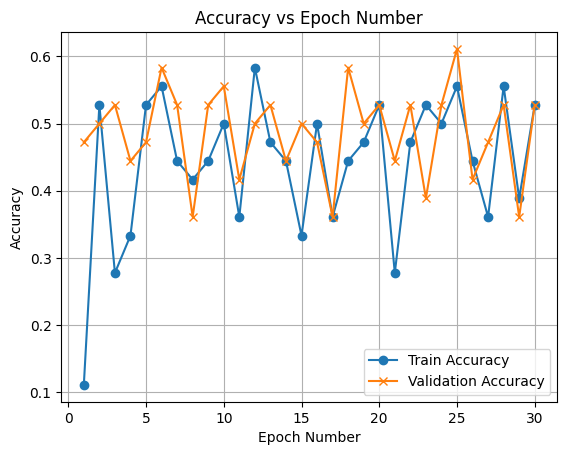

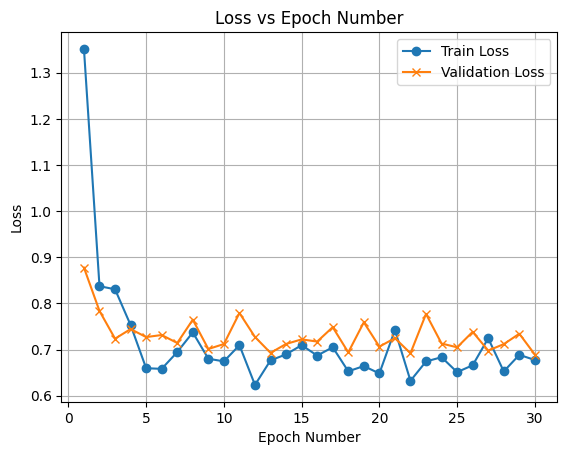

Epoch 1/30 => Train Loss: 0.64784, Train Accuracy: 55.56%, Validation Loss: 0.69616, Validation Accuracy: 47.22%
Epoch 2/30 => Train Loss: 0.65382, Train Accuracy: 55.56%, Validation Loss: 0.71672, Validation Accuracy: 47.22%
Epoch 3/30 => Train Loss: 0.66665, Train Accuracy: 52.78%, Validation Loss: 0.69333, Validation Accuracy: 52.78%
Hi Oren
Epoch 4/30 => Train Loss: 0.64707, Train Accuracy: 52.78%, Validation Loss: 0.65687, Validation Accuracy: 55.56%
Hi Oren
Epoch 5/30 => Train Loss: 0.61211, Train Accuracy: 58.33%, Validation Loss: 0.58900, Validation Accuracy: 77.78%
Epoch 6/30 => Train Loss: 0.58472, Train Accuracy: 63.89%, Validation Loss: 0.46923, Validation Accuracy: 83.33%
Epoch 7/30 => Train Loss: 0.42399, Train Accuracy: 72.22%, Validation Loss: 0.33497, Validation Accuracy: 83.33%
Epoch 8/30 => Train Loss: 0.38596, Train Accuracy: 72.22%, Validation Loss: 0.44682, Validation Accuracy: 75.00%
Hi Oren
Epoch 9/30 => Train Loss: 0.49437, Train Accuracy: 69.44%, Validation Lo

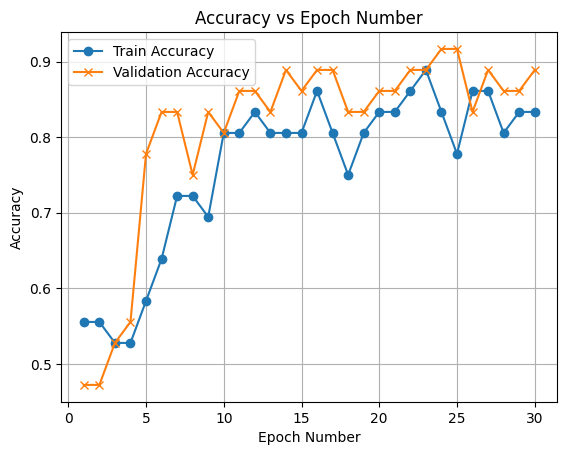

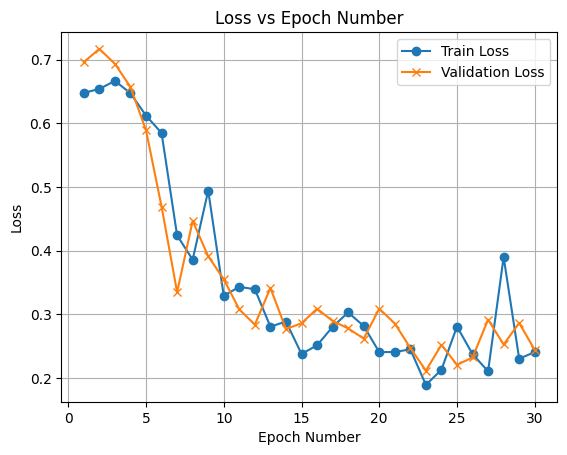

In [20]:
reload_functions()
import ML_DL_Functions3
# Write your code here. Remember to include your results so that we can
train_data_sanity_check = train_data[0:6]
valid_data_sanity_check = train_data_sanity_check

print(train_data.size)
# see that your model attains a high training accuracy.

print(train_data.shape)

modelCNN = ML_DL_Functions3.CNN()
train_losses, valid_losses, train_accs, valid_accs = train_model(modelCNN, train_data_sanity_check ,test_m_data,test_w_data,
                                                                     valid_data_sanity_check, batch_size = 2, learning_rate = 0.001,
                                                                     weight_decay=0.0001, epochs=30, train = False,type=1)

modelCNNChannel = ML_DL_Functions3.CNNChannel()
train_losses, valid_losses, train_accs, valid_accs = train_model(modelCNNChannel, train_data_sanity_check,test_m_data,test_w_data,
                                                                      valid_data_sanity_check, batch_size=2,
                                                                      learning_rate=0.001,
                                                                      weight_decay=0.0001, epochs=30, train = False,type=2)


### 3.3 training and saving the optimal model

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, choose your hyperparameters run the training and save the model in the drive. You should try to save the your **single best** model.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using.  Remember to submit the model with your code in the moodle submission.

It is recommended to plot the training curves.

<ipython-input-19-5fa8acfd2194>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(inputs)


Epoch 1/100 => Train Loss: 3.53869, Train Accuracy: 42.38%, Validation Loss: 0.73240, Validation Accuracy: 52.90%
Epoch 2/100 => Train Loss: 2.87976, Train Accuracy: 50.98%, Validation Loss: 0.70631, Validation Accuracy: 56.52%
Epoch 3/100 => Train Loss: 2.85169, Train Accuracy: 50.00%, Validation Loss: 0.71707, Validation Accuracy: 50.00%
Hi Oren
Epoch 4/100 => Train Loss: 2.79477, Train Accuracy: 55.47%, Validation Loss: 0.67374, Validation Accuracy: 58.70%
Hi Oren
Epoch 5/100 => Train Loss: 2.73348, Train Accuracy: 54.10%, Validation Loss: 0.67093, Validation Accuracy: 56.52%
Epoch 6/100 => Train Loss: 2.79888, Train Accuracy: 52.15%, Validation Loss: 0.64370, Validation Accuracy: 59.42%
Epoch 7/100 => Train Loss: 2.64120, Train Accuracy: 57.81%, Validation Loss: 0.63647, Validation Accuracy: 64.49%
Epoch 8/100 => Train Loss: 2.61740, Train Accuracy: 61.13%, Validation Loss: 0.63832, Validation Accuracy: 63.04%
Hi Oren
Epoch 9/100 => Train Loss: 2.59522, Train Accuracy: 60.55%, Vali

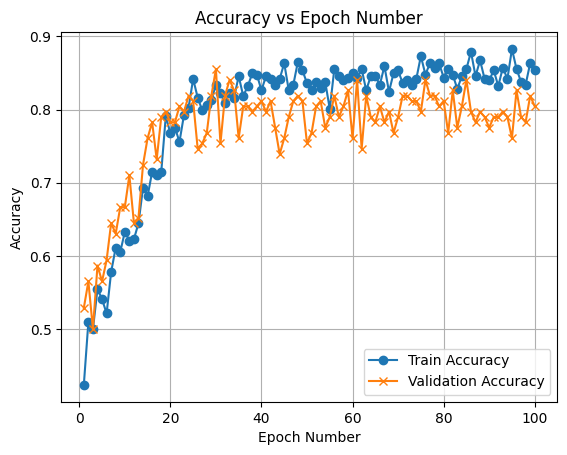

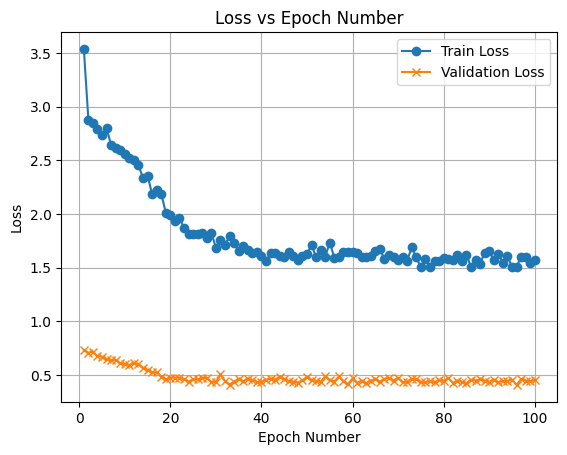

Epoch 1/100 => Train Loss: 2.77392, Train Accuracy: 50.98%, Validation Loss: 0.67622, Validation Accuracy: 63.77%
Epoch 2/100 => Train Loss: 2.58500, Train Accuracy: 64.65%, Validation Loss: 0.51437, Validation Accuracy: 77.54%
Epoch 3/100 => Train Loss: 2.16126, Train Accuracy: 71.29%, Validation Loss: 0.40829, Validation Accuracy: 82.61%
Epoch 4/100 => Train Loss: 1.86979, Train Accuracy: 80.66%, Validation Loss: 0.39022, Validation Accuracy: 84.06%
Hi Oren
Epoch 5/100 => Train Loss: 1.75093, Train Accuracy: 81.45%, Validation Loss: 0.39484, Validation Accuracy: 82.61%
Epoch 6/100 => Train Loss: 1.81914, Train Accuracy: 80.66%, Validation Loss: 0.42850, Validation Accuracy: 84.06%
Epoch 7/100 => Train Loss: 1.75720, Train Accuracy: 81.64%, Validation Loss: 0.36443, Validation Accuracy: 84.78%
Hi Oren
Epoch 8/100 => Train Loss: 1.64146, Train Accuracy: 83.59%, Validation Loss: 0.39033, Validation Accuracy: 82.61%
Epoch 9/100 => Train Loss: 1.71661, Train Accuracy: 79.49%, Validation L

In [ ]:
reload_functions()
import ML_DL_Functions3
CNN_model = ML_DL_Functions3.CNN() # this has to be the blueprint for the model(don't add arguments)
CNNChannel_model = ML_DL_Functions3.CNNChannel() # this has to be the blueprint for the model(don't add arguments)

# Insert your training here


train_losses_CNN, valid_losses_CNN, train_accs_CNN, valid_accs_CNN = train_model(
        CNN_model, train_data,test_m_data,test_w_data,
        valid_data, batch_size=32,
        learning_rate=0.001,
        weight_decay=0.0001, epochs=100,
        model_name = 'CNN', train = True, type=1)

train_loss_CNNChannel, valid_loss_CNNChannel, train_acc_CNNChannel, valid_acc_CNNChannel = train_model(
        CNNChannel_model, train_data,test_m_data,test_w_data,
        valid_data, batch_size=32,
        learning_rate=0.001,
        weight_decay=0.0001, epochs=100,
        model_name = 'CNNChannel', train = True,type=2)



In [22]:
# Run the following code and submit to the moodle the two models saved
checkpoint_path  = drive_path+"checkpoints/" # you can change the path
torch.save(CNN_model.state_dict(), checkpoint_path+"best_CNN_model.pk") # Do not change the name of the checkpoint file
torch.save(CNNChannel_model.state_dict(), checkpoint_path+"best_CNNChannel_model.pk") # Do not change the name of the checkpoint file

## 4. Testing


This part is mainly to help you get a feeling of your models performance. It should not take you long to finish.

### 4.1. Accuracies

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [24]:
reload_functions()
from pathlib import Path

import ML_DL_Functions3
# Write your code here.
checkpoint_path_cnn = Path('/content/gdrive/My Drive/Colab Notebooks/ML HW3/checkpoints/best_CNN_model.pk')
best_CNN_model = ML_DL_Functions3.CNN()
best_CNN_model.load_state_dict(torch.load(checkpoint_path_cnn))

checkpoint_path_channel = Path('/content/gdrive/My Drive/Colab Notebooks/ML HW3/checkpoints/best_CNNChannel_model.pk')
best_CNNChannel_model = ML_DL_Functions3.CNNChannel()
best_CNNChannel_model.load_state_dict(torch.load(checkpoint_path_channel))



pos_men_CNN = 0
neg_men_CNN = 0
pos_women_CNN = 0
neg_women_CNN = 0
pos_men_CNNChannel = 0
neg_men_CNNChannel = 0
pos_women_CNNChannel = 0
neg_women_CNNChannel = 0

pos_men_CNN, neg_men_CNN = get_accuracy(best_CNN_model, test_m_data)
pos_women_CNN, neg_women_CNN = get_accuracy(best_CNN_model, test_w_data)
pos_men_CNNChannel, neg_men_CNNChannel = get_accuracy(best_CNNChannel_model, test_m_data)
pos_women_CNNChannel, neg_women_CNNChannel = get_accuracy(best_CNNChannel_model, test_w_data)

print("CNN: Positive accuracy over the men's test dataset: {:.2f}%, Negative accuracy: {:.2f}%, Mean {:.2f}%".format(100 * pos_men_CNN, 100 * neg_men_CNN,100 * pos_men_CNN/2+ 100 * neg_men_CNN/2))
print("CNN: Positive accuracy over the women's test dataset: {:.2f}%, Negative accuracy: {:.2f}%, Mean {:.2f}%".format(100 * pos_women_CNN, 100 * neg_women_CNN,100 * pos_women_CNN/2+ 100 * neg_women_CNN/2))
print("Mean accuracf for CNN is: {:.2f}%".format(100 * pos_men_CNN/4+ 100 * neg_men_CNN/4+100*pos_women_CNN/4+ 100 * neg_women_CNN/4))
print("CNNChannel: Positive accuracy over the men's test dataset: {:.2f}%, Negative accuracy: {:.2f}%, Mean {:.2f}%".format(100 * pos_men_CNNChannel, 100 * neg_men_CNNChannel,100 * pos_men_CNNChannel/2+ 100 * neg_men_CNNChannel/2))
print("CNNChannel: Positive accuracy over the women's test dataset: {:.2f}%, Negative accuracy: {:.2f}%, Mean {:.2f}%".format(100 * pos_women_CNNChannel, 100 * neg_women_CNNChannel,100 * pos_women_CNNChannel/2+ 100 * neg_women_CNNChannel/2))
print("Mean accuracf for CNNChannel is: {:.2f}%".format(100 * pos_men_CNNChannel/4+ 100 * neg_men_CNNChannel/4+100*pos_women_CNNChannel/4+ 100 * neg_women_CNNChannel/4))





CNN: Positive accuracy over the men's test dataset: 93.33%, Negative accuracy: 60.00%, Mean 76.67%
CNN: Positive accuracy over the women's test dataset: 96.67%, Negative accuracy: 60.00%, Mean 78.33%
Mean accuracf for CNN is: 77.50%
CNNChannel: Positive accuracy over the men's test dataset: 66.67%, Negative accuracy: 63.33%, Mean 65.00%
CNNChannel: Positive accuracy over the women's test dataset: 90.00%, Negative accuracy: 56.67%, Mean 73.33%
Mean accuracf for CNNChannel is: 69.17%


Notice that this testing has a random element to it, depending on which images where chosen in the generate pairs. In order to grade your code the testing will be run multiple times to reduce the randomness.

### 4.2 Men's Shoes example

Display one set of men's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.


In [ ]:
# Write your code here.
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Ignore the warning about clipping input data

pos_test_m_data = generate_same_pair(test_m_data)
same_flag = False
dif_flag = False
print(pos_test_m_data.shape)
# Make inputs
pos_test_m_data_reshaped = pos_test_m_data.reshape(-1, 448, 224, 3)
print(pos_test_m_data_reshaped.shape)
input_tensor = torch.from_numpy(pos_test_m_data_reshaped).permute(0, 3, 1, 2).float()

# Make label
label = torch.ones(1).long()

i = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

while not same_flag and i < len(input_tensor):
    input_pic = input_tensor[i]
    output = best_CNNChannel_model(input_pic.unsqueeze(0))
    accuracy = ((output.argmax(dim=1) == label).sum().item()) / label.size(0)
    if accuracy == 1:
        print(i)
        axes[0].imshow(np.transpose(input_pic.numpy(), (1, 2, 0)))  # Transpose to (448, 224, 3)
        axes[0].set_title("Positive pair that the model correctly classified", fontsize=15)
        same_flag = True
    i += 1

print("Next step")
i = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

while not dif_flag and i < len(input_tensor):
    input_pic = input_tensor[i]
    output = best_CNNChannel_model(input_pic.unsqueeze(0))
    accuracy = ((output.argmax(dim=1) == label).sum().item()) / label.size(0)
    if accuracy == 0:
        print(i)
        axes[0].imshow(np.transpose(input_pic.numpy(), (1, 2, 0)))  # Transpose to (448, 224, 3)
        axes[0].set_title("Positive pair that the model incorrectly classified", fontsize=15)
        dif_flag = True
    i += 1



### 4.2 Women's Shoes example

Display one set of women's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.

In [ ]:
# Write your code here.
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Ignore the warning about clipping input data

pos_test_w_data = generate_same_pair(test_w_data)
same_flag = False
dif_flag = False
print(pos_test_w_data.shape)
# Make inputs
pos_test_w_data_reshaped = pos_test_w_data.reshape(-1, 448, 224, 3)
print(pos_test_w_data_reshaped.shape)
input_tensor = torch.from_numpy(pos_test_w_data_reshaped).permute(0, 3, 1, 2).float()

# Make label
label = torch.ones(1).long()

i = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

while not same_flag and i < len(input_tensor):
    input_pic = input_tensor[i]
    output = best_CNNChannel_model(input_pic.unsqueeze(0))
    accuracy = ((output.argmax(dim=1) == label).sum().item()) / label.size(0)
    if accuracy == 1:
        print(i)
        axes[0].imshow(np.transpose(input_pic.numpy(), (1, 2, 0)))  # Transpose to (448, 224, 3)
        axes[0].set_title("Positive pair that the model correctly classified", fontsize=15)
        same_flag = True
    i += 1

print("Next step")
i = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

while not dif_flag and i < len(input_tensor):
    input_pic = input_tensor[i]
    output = best_CNNChannel_model(input_pic.unsqueeze(0))
    accuracy = ((output.argmax(dim=1) == label).sum().item()) / label.size(0)
    if accuracy == 0:
        print(i)
        axes[0].imshow(np.transpose(input_pic.numpy(), (1, 2, 0)))  # Transpose to (448, 224, 3)
        axes[0].set_title("Positive pair that the model incorrectly classified", fontsize=15)
        dif_flag = True
    i += 1
